In [1]:
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import xarray as xr
from rasterio.mask import mask
from shapely.geometry import box

In [2]:
gdp_path = "data/GDP_per_capita_PPP_1990_2015_v2.nc"
pop_path = "data/ppp_2013_1km_Aggregated.tif"

gdp_output = "output/GDP_per_capita_PPP_1990_2015_v2.nc"
pop_output = "output/ppp_2013_1km_Aggregated.tif"

In [3]:
regions = gpd.read_file("data/regions_onshore.geojson")
regions = (
        regions.rename(columns={"name": "Bus"})
        .drop(columns=["x", "y"])
        .set_index("Bus")
    )
countries_non_nuts3 = pd.Index(("MD", "UA"))
regions = regions[regions["country"].isin(countries_non_nuts3)]

In [4]:
bounding_box = (
        gpd.GeoDataFrame(geometry=[box(*regions.total_bounds)], crs=regions.crs)
        .to_crs(epsg=3857)
        .buffer(10000)
        .to_crs(regions.crs)
    )

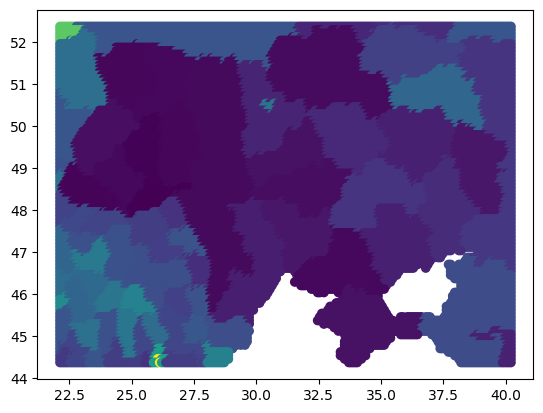

In [5]:
# GDP UA, MD
with xr.open_dataset(gdp_path) as src_gdp:
    src_gdp = src_gdp.where(
        (src_gdp.longitude >= bounding_box.bounds.minx.min())
        & (src_gdp.longitude <= bounding_box.bounds.maxx.max())
        & (src_gdp.latitude >= bounding_box.bounds.miny.min())
        & (src_gdp.latitude <= bounding_box.bounds.maxy.max()),
        drop=True,
    )
src_gdp.to_netcdf(gdp_output)

df_gdp = src_gdp.to_dataframe().reset_index()
df_gdp = df_gdp[df_gdp.time == df_gdp.time.max()]
fig, ax = plt.subplots()
ax.scatter(df_gdp.longitude, df_gdp.latitude, c=df_gdp["GDP_per_capita_PPP"])

plt.show()

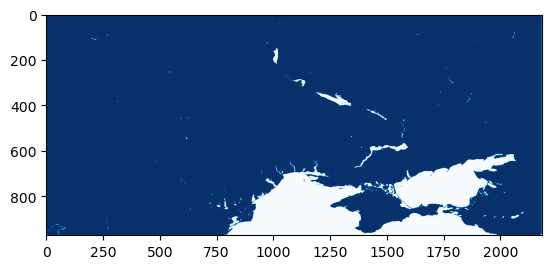

In [6]:
# GOP UA, MD
with rasterio.open(pop_path) as src_pop:
    # Mask the raster with the bounding box
    out_image, out_transform = mask(src_pop, bounding_box, crop=True)
    out_image,
    out_meta = src_pop.meta.copy()
    out_meta.update(
        {
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
        }
    )

# export to pop_output
with rasterio.open(pop_output, "w", **out_meta) as dst:
    dst.write(out_image)

fig, ax = plt.subplots()
ax.imshow(out_image[0], cmap="Blues")
plt.show()